In [1]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Flatten, Dense
from tensorflow.keras import Model
from tensorflow.keras.datasets import mnist
import numpy as np
import matplotlib.pyplot as plt

In [2]:
(X_train, y_train), (X_test, y_test) = mnist.load_data()

In [3]:
X_train = X_train.reshape(X_train.shape[0], 28, 28, 1).astype(np.float32)

In [4]:
inputs = Input(shape=(28,28,1))
out = Flatten()(inputs)
out = Dense(10, bias_initializer='random_normal')(out)
model = Model(inputs, out)

In [5]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 28, 28, 1)]       0         
                                                                 
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 10)                7850      
                                                                 
Total params: 7,850
Trainable params: 7,850
Non-trainable params: 0
_________________________________________________________________


In [6]:
def representative_data_gen():
  for input_value in tf.data.Dataset.from_tensor_slices(X_train).batch(1).take(100):
    # Model has only one input so each data point has one element.
    yield [input_value]

In [7]:
converter = tf.lite.TFLiteConverter.from_keras_model(model)
converter.optimizations = [tf.lite.Optimize.DEFAULT]
converter.representative_dataset = representative_data_gen
converter.target_spec.supported_ops = [tf.lite.OpsSet.TFLITE_BUILTINS_INT8]
# converter.inference_input_type = tf.int8
# converter.inference_output_type = tf.int8
converter._experimental_disable_per_channel = True
tflite_quant_model = converter.convert()

INFO:tensorflow:Assets written to: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmp962u7x4y/assets


/Users/sty/miniforge3/envs/tf-cpu/lib/python3.9/site-packages/tensorflow/lite/python/convert.py:766: UserWarning: Statistics for quantized inputs were expected, but not specified; continuing anyway.
  warnings.warn("Statistics for quantized inputs were expected, but not "
2022-12-08 21:44:36.740640: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:362] Ignored output_format.
2022-12-08 21:44:36.740652: W tensorflow/compiler/mlir/lite/python/tf_tfl_flatbuffer_helpers.cc:365] Ignored drop_control_dependency.
2022-12-08 21:44:36.740776: I tensorflow/cc/saved_model/reader.cc:45] Reading SavedModel from: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmp962u7x4y
2022-12-08 21:44:36.741133: I tensorflow/cc/saved_model/reader.cc:89] Reading meta graph with tags { serve }
2022-12-08 21:44:36.741139: I tensorflow/cc/saved_model/reader.cc:130] Reading SavedModel debug info (if present) from: /var/folders/gt/sg3v8rd13l52jx91mfbgzbfc0000gn/T/tmp962u7x4y
2022-12-08 21:44:36.741

In [8]:
'''
Create interpreter, allocate tensors
'''
tflite_interpreter = tf.lite.Interpreter(model_content=tflite_quant_model)
tflite_interpreter.allocate_tensors()

'''
Check input/output details
'''
input_details = tflite_interpreter.get_input_details()
output_details = tflite_interpreter.get_output_details()

print("== Input details ==")
print("name:", input_details[0]['name'])
print("shape:", input_details[0]['shape'])
print("type:", input_details[0]['dtype'])
print("\n== Output details ==")
print("name:", output_details[0]['name'])
print("shape:", output_details[0]['shape'])
print("type:", output_details[0]['dtype'])

'''
This gives a list of dictionaries. 
'''
tensor_details = tflite_interpreter.get_tensor_details()

for dict in tensor_details:
    i = dict['index']
    tensor_name = dict['name']
    scales = dict['quantization'][0]
    zero_points = dict['quantization'][1]
    tensor = tflite_interpreter.tensor(i)()

    #print(i, type, tensor_name, scales.shape, zero_points.shape, tensor.shape)
    print(dict)
    if "MatMul" in tensor_name:
        weights = tensor
        scale = scales
        print(tensor)
    if "BiasAdd" in tensor_name:
        biases = tensor
        print(tensor)

== Input details ==
name: serving_default_input_1:0
shape: [ 1 28 28  1]
type: <class 'numpy.float32'>

== Output details ==
name: StatefulPartitionedCall:0
shape: [ 1 10]
type: <class 'numpy.float32'>
{'name': 'serving_default_input_1:0', 'index': 0, 'shape': array([ 1, 28, 28,  1], dtype=int32), 'shape_signature': array([-1, 28, 28,  1], dtype=int32), 'dtype': <class 'numpy.float32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'model/flatten/Const', 'index': 1, 'shape': array([2], dtype=int32), 'shape_signature': array([2], dtype=int32), 'dtype': <class 'numpy.int32'>, 'quantization': (0.0, 0), 'quantization_parameters': {'scales': array([], dtype=float32), 'zero_points': array([], dtype=int32), 'quantized_dimension': 0}, 'sparsity_parameters': {}}
{'name': 'model/dense/BiasAdd/ReadVariableOp', 'index': 2, 'shape': array([10], dtype=int3

INFO: Initialized TensorFlow Lite runtime.
INFO: Applying 1 TensorFlow Lite delegate(s) lazily.


In [9]:
weights = np.rollaxis(weights, 1)

In [10]:
A = weights*scale
A

array([[-0.06089774,  0.05610803,  0.01573762, ..., -0.08074082,
         0.02463279,  0.05473954],
       [-0.03831768,  0.02873826,  0.04926559, ..., -0.07663536,
        -0.04516012, -0.08553053],
       [-0.05337105,  0.05610803,  0.00821093, ..., -0.04926559,
        -0.05884501,  0.04858134],
       ...,
       [-0.00752669,  0.00205273,  0.0355807 , ...,  0.04447588,
         0.02258006, -0.02463279],
       [-0.05268681,  0.03079099, -0.08689902, ..., -0.04652861,
        -0.04994983, -0.02668553],
       [-0.05473954, -0.06979292, -0.0061582 , ..., -0.07937233,
         0.0711614 ,  0.0123164 ]])

In [11]:
B = model.weights[0].numpy()
B

array([[-0.06092265,  0.05608409,  0.01604027, ..., -0.08041564,
         0.0247317 ,  0.054695  ],
       [-0.03802602,  0.02875879,  0.0495318 , ..., -0.07685173,
        -0.04518023, -0.08525494],
       [-0.05338888,  0.05628017,  0.0084509 , ..., -0.04941986,
        -0.05888065,  0.04838545],
       ...,
       [-0.00763592,  0.00184766,  0.03528694, ...,  0.04417472,
         0.02250248, -0.02448751],
       [-0.05262804,  0.03108874, -0.0865635 , ..., -0.04625238,
        -0.04969141, -0.02692351],
       [-0.05462288, -0.06955189, -0.00646332, ..., -0.07964899,
         0.07138715,  0.01246802]], dtype=float32)

In [12]:
((A-B)**2).mean()**.5

0.00019894641616053846

In [13]:
A = biases*scale
A

array([ 0.06363472, -0.01436913, -0.01573762, -0.04379163,  0.09853117,
       -0.08689902,  0.00889518, -0.01984308,  0.05542379, -0.07937233])

In [14]:
B = model.weights[1].numpy()
B

array([ 0.06382733, -0.01428847, -0.01605221, -0.04355662,  0.09886094,
       -0.08723756,  0.00919785, -0.02015752,  0.05540981, -0.07915401],
      dtype=float32)

In [15]:
((A-B)**2).mean()**.5

0.0002568072114758864

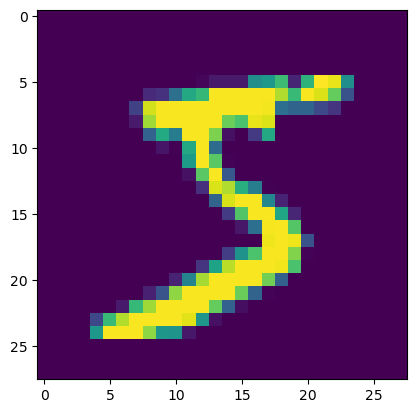

In [16]:
X = X_train[[0]]
plt.imshow(X[0])

In [17]:
y = model.predict(X)
y

1/1 [==============================] - 0s 36ms/step


array([[ -68.18071  ,   54.53226  , -274.3156   ,    6.4311633,
          63.187294 ,  -95.02882  ,  -32.228554 ,  264.74173  ,
          54.89625  ,   37.296173 ]], dtype=float32)

In [18]:
in_json = {
    "in": X.astype(int).flatten().tolist(),
    "weights": weights.flatten().tolist(),
    "bias": biases.flatten().tolist(),
}

In [19]:
out_json = {
    "scale": scale,
    "out": y.flatten().tolist(),
}

In [20]:
import json

In [21]:
with open("dense_input.json", "w") as f:
    json.dump(in_json, f)

In [22]:
with open("dense_output.json", "w") as f:
    json.dump(out_json, f)